In [436]:
import os
import sys
import yaml 
from collections import defaultdict
import pickle as pkl
sys.path.append('/home/songzhu/UAPAttack/')
os.chdir('/home/songzhu/UAPAttack')

import torch
import torchvision.transforms.functional as VF

from data.data_builder import DATA_BUILDER
from networks import NETWORK_BUILDER
from utils import DENORMALIZER

root = "/home/songzhu/UAPAttack"
trigger = pkl.load(open('/scr/songzhu/trojai/uapattack/triggers/cifar10_resnet18_ulp_source0_seed77.pkl', 'rb'))

In [437]:
with open(os.path.join(root, 'experiment_configuration.yml')) as f:
    config = yaml.safe_load(f)
f.close()
config['args'] = defaultdict(str)
config['args']['dataset'] = 'cifar10'
config['args']['network'] = 'resnet18'
config['args']['method']  = 'badnet'
config['network']['PRETRAINED'] = True
config['train']['DISTRIBUTED']  =False

denormalizer = DENORMALIZER(
    mean = (0.4914, 0.4822, 0.4465), 
    std  = (0.2023, 0.1994, 0.2010), 
    config = config
)

# Build dataset
dataset = DATA_BUILDER(config=config)
dataset.build_dataset()

testloader = torch.utils.data.DataLoader(dataset.testset, batch_size=124, shuffle=False)

# Build network
model = NETWORK_BUILDER(config=config)
model.build_network()
model.model = model.model.cuda()

Files already downloaded and verified
Files already downloaded and verified


In [446]:
correct_ulp = 0
correct_random = 0
total = 0

trigger[0] = trigger[0].cuda()

trigger_random = torch.randn(trigger[0].shape).cuda()
trigger_random = trigger_random/torch.norm(trigger_random, p=2)*9

multipliers = [1, 5, 10, 15, 20, 25, 30, 35]
ulp_asr = []
random_trigger_asr = []

model.model.eval()
for multiplier in multipliers:
    
    correct_ulp = 0
    correct_random = 0
    total = 0
    
    for _, (ind, img, _, _) in enumerate(testloader):

        img = img.cuda()
        labels = dataset.testset.labels_c[ind]

        img_troj = VF.normalize(torch.clamp(0.5*img + 0.5*multiplier*trigger[0].permute(0, 3, 1, 2), 0, 1), 
                                mean = (0.4914, 0.4822, 0.4465), 
                                std  = (0.2023, 0.1994, 0.2010))
        correct_ulp += (model.model(img_troj).argmax(1).eq(1).sum()).item()

        img_troj = VF.normalize(torch.clamp(0.5*img + 0.5*multiplier*trigger_random.permute(0, 3, 1, 2), 0, 1), 
                            mean = (0.4914, 0.4822, 0.4465), 
                            std  = (0.2023, 0.1994, 0.2010))
        correct_random += (model.model(img_troj).argmax(1).eq(1).sum()).item()

        total += len(img)
    
    ulp_asr.append(correct_ulp/total)
    random_trigger_asr.append(correct_random/total)

/home/songzhu/UAPAttack/data/CIFAR.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels_c)
/home/songzhu/UAPAttack/data/CIFAR.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_t = torch.tensor(labels_t)


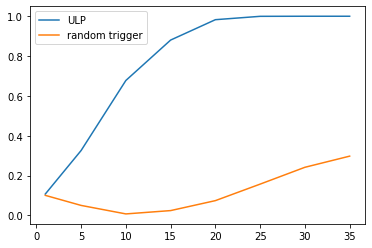

In [448]:
plt.plot(multipliers, ulp_asr, label='ULP')
plt.plot(multipliers, random_trigger_asr, label='random trigger')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


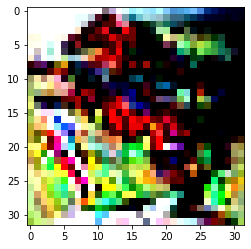

In [431]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(denormalizer(img_troj).detach().cpu()[3].squeeze().permute(1,2,0).numpy())